# Analyze and Prepare the Boston Housing Dataset

This notebook is based on [this](https://www.manning.com/liveproject/data-preprocessing) course. It contains a few parts of code given by authors in partial solution file. 

In [1]:
using DelimitedFiles
using CSV
using HTTP
using SHA
using DataFrames
using FreqTables
using Plots
using StatsBase
using Arrow

<b>1. Use the "housing.data" file from the UCI repository. You can learn more about the dataset from the "housing.names" file also available on UCI data repository. You should download the file from the internet using Julia. In your code make sure to download it only if it is not already present in the local folder.</b>

In [2]:
isfile("housing.data")||HTTP.download("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data","housing.data");
isfile("housing.names")||HTTP.download("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names","housing.names");

<b>2. Check that file has been fetched correctly by calculating its SHA1 hash and compare it to the following reference value:

[0xad, 0xfa, 0x6b, 0x6d, 0xca,
 0x24, 0xa6, 0x3f, 0xe1, 0x66,
 0xa9, 0xe7, 0xfa, 0x01, 0xce,
 0xe4, 0x33, 0x58, 0x57, 0xd1]</b>

In [3]:
housing_sha1= open("housing.data") do f
    sha1(f)
    end;

In [4]:
check = [0xad, 0xfa, 0x6b, 0x6d, 0xca,
 0x24, 0xa6, 0x3f, 0xe1, 0x66,
 0xa9, 0xe7, 0xfa, 0x01, 0xce,
 0xe4, 0x33, 0x58, 0x57, 0xd1];

In [5]:
housing_sha1==check

true

In [6]:
println(String(read("housing.names")))

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

<b>3. Load data into Julia’s DataFrame. Examine the basic descriptive statistics of the dataset.</b>

In [7]:
df = CSV.read("housing.data",DataFrame,
    header=[:CRIM,:ZN,:INDUS,:CHAS,:NOX,:RM,:AGE,:DIS,:RAD,
        :TAX,:PTRATIO,:B,:LSTAT,:MEDV],
    delim=' ', ignorerepeated=true, ntasks=1);

In [8]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,CRIM,3.61352,0.00632,0.25651,88.9762,0,Float64
2,ZN,11.3636,0.0,0.0,100.0,0,Float64
3,INDUS,11.1368,0.46,9.69,27.74,0,Float64
4,CHAS,0.06917,0,0.0,1,0,Int64
5,NOX,0.554695,0.385,0.538,0.871,0,Float64
6,RM,6.28463,3.561,6.2085,8.78,0,Float64
7,AGE,68.5749,2.9,77.5,100.0,0,Float64
8,DIS,3.79504,1.1296,3.20745,12.1265,0,Float64
9,RAD,9.54941,1,5.0,24,0,Int64


<b>4. Identify nominal and continuous variables in the dataset. Create two variables nominal and continuous that will store vectors holding the column names.</b>

In [9]:
continuous=names(df,Float64);
nominal = names(df,Int64);

<b>5. Inspect the distribution of nominal variables. To do this produce tables with the counts of each level for all nominal variables.</b>

In [10]:
for name in nominal
    show(proptable(df,name))
    println()
end

2-element Named Vector{Float64}
CHAS  │ 
──────┼────────
0     │ 0.93083
1     │ 0.06917
9-element Named Vector{Float64}
RAD  │ 
─────┼──────────
1    │ 0.0395257
2    │ 0.0474308
3    │ 0.0750988
4    │  0.217391
5    │  0.227273
6    │ 0.0513834
7    │ 0.0335968
8    │ 0.0474308
24   │   0.26087


<b>6. Check the distributions of continuous variables by producing histograms for each variable. You should produce a plot (or plots) similar to the one below.</b>

In [11]:
histogram_helper(col_name)=
    histogram(df[!,col_name],legend=false)

histogram_helper (generic function with 1 method)

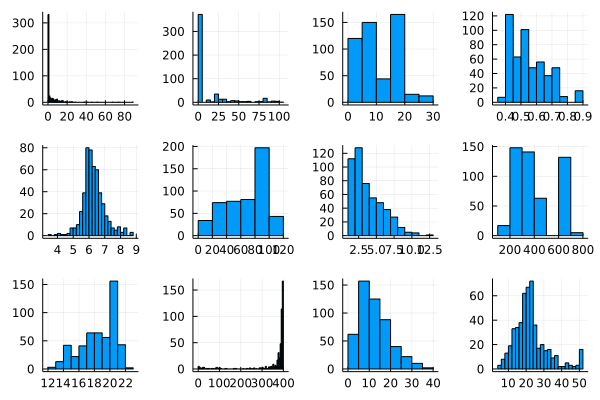

In [12]:
plot(map(x -> histogram_helper(x), continuous)..., layout=grid(3, 4))

<b>7. The analysis of histograms unveils a pattern in the target (MEDV) variable there is a strange spike for the highest value of the median house price (confirm in your code that it is 50.0). There are several different ways to handle this situation. For the purpose of this project, remove observations with MEDV equal to 50.0 as we cannot be sure about the quality of this information.</b>

In [13]:
freqtable(df,:MEDV)

229-element Named Vector{Int64}
MEDV  │ 
──────┼───
5.0   │  2
5.6   │  1
6.3   │  1
7.0   │  2
7.2   │  3
7.4   │  1
7.5   │  1
8.1   │  1
8.3   │  2
8.4   │  2
8.5   │  2
⋮        ⋮
43.5  │  1
43.8  │  1
44.0  │  1
44.8  │  1
45.4  │  1
46.0  │  1
46.7  │  1
48.3  │  1
48.5  │  1
48.8  │  1
50.0  │ 16

In [14]:
filter!(row->row.MEDV!=50,df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222.0
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0


<b>8. Produce Kendall’s Tau correlation matrix of variables. We can analyze relationships between all ordinal and continuous features this way. Additionally, Kendall’s correlation assumes that feature relations are monotonic but not necessarily linear, as in the case of Pearson’s correlation. You can check the “Pearson vs Spearman vs Kendall” thread in an online discussion group for more information about main correlation coefficients.</b>

In [15]:
matrix_cor=corkendall(Matrix(df))

14×14 Matrix{Float64}:
  1.0        -0.458266    0.520867   …  -0.255792    0.483386    -0.438928
 -0.458266    1.0        -0.530466       0.121932   -0.399438     0.3565
  0.520867   -0.530466    1.0           -0.185451    0.493072    -0.448465
  0.0187153  -0.0364009   0.0570377     -0.026583    0.00639807   0.0700622
  0.594802   -0.514629    0.616625      -0.193448    0.479634    -0.428623
 -0.218774    0.279787   -0.299508   …   0.0382782  -0.455255     0.471074
  0.489837   -0.424882    0.483657      -0.145344    0.522331    -0.427413
 -0.5359      0.484681   -0.57237        0.157373   -0.452619     0.360628
  0.556161   -0.224992    0.350976      -0.206419    0.30502     -0.270892
  0.535601   -0.273946    0.474513      -0.237354    0.402941    -0.440709
  0.316977   -0.357918    0.341488   …  -0.0448801   0.32111     -0.396202
 -0.255792    0.121932   -0.185451       1.0        -0.163366     0.152093
  0.483386   -0.399438    0.493072      -0.163366    1.0         -0.658586
 -0

<b>9. Visualize the correlation matrix as a heatmap, sorting the rows and columns by the correlation with the MEDV target variable. Heatmaps are often used to visualize correlation matrices as color scales to help easily spot the most and least correlated features in the dataset. You should produce a plot similar to the one below.</b>

In [16]:
ord=sortperm(matrix_cor[:,end])

14-element Vector{Int64}:
 13
  3
 10
  1
  5
  7
 11
  9
  4
 12
  2
  8
  6
 14

In [17]:
DataFrame(matrix_cor)

,x1,x2,x3,x4,x5,x6,x7
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.458266,0.520867,0.0187153,0.594802,-0.218774,0.489837
2,-0.458266,1.0,-0.530466,-0.0364009,-0.514629,0.279787,-0.424882
3,0.520867,-0.530466,1.0,0.0570377,0.616625,-0.299508,0.483657
4,0.0187153,-0.0364009,0.0570377,1.0,0.046477,0.0163709,0.0384825
5,0.594802,-0.514629,0.616625,0.046477,1.0,-0.224779,0.587438
6,-0.218774,0.279787,-0.299508,0.0163709,-0.224779,1.0,-0.19728
7,0.489837,-0.424882,0.483657,0.0384825,0.587438,-0.19728,1.0
8,-0.5359,0.484681,-0.57237,-0.0376498,-0.685598,0.197309,-0.606725
9,0.556161,-0.224992,0.350976,0.00896455,0.426594,-0.0708855,0.296536


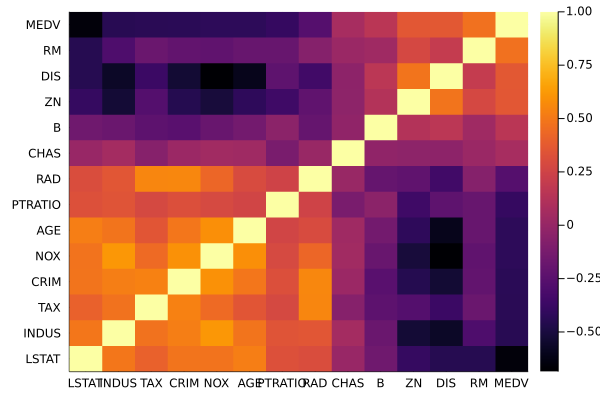

In [18]:
heatmap(names(df)[ord],names(df)[ord],matrix_cor[ord,ord])

<b>10. Produce a data frame showing all variables and their correlation with MEDV. Sort this data frame by absolute value of correlation (to group together the least and most correlated variables).</b>

In [19]:
cor_df=DataFrame(Var = names(df), Cor_MEDV=matrix_cor[:, end])
cor_df[sortperm(broadcast(abs,matrix_cor[:, end])),:]

,Var,Cor_MEDV
,String,Float64
1,CHAS,0.0700622
2,B,0.152093
3,RAD,-0.270892
4,ZN,0.3565
5,DIS,0.360628
6,PTRATIO,-0.396202
7,AGE,-0.427413
8,NOX,-0.428623
9,CRIM,-0.438928


<b>11. Plot each continuous variable on a scatterplot against the MEDV variable and add a linear regression estimate to the plot. We want to visually assess the linearity of the relationship with the target variable. You should produce a plot (or plots) similar to the one below.<b/>

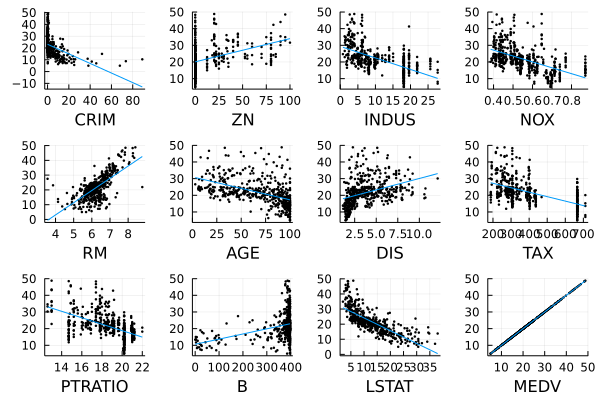

In [20]:
scatter_helper(colname)=
    scatter(df[!,colname],df[!,:MEDV],legend=false,xaxis=colname,smooth=true,markersize=1.5,markercolor=:black)
plot(map(x -> scatter_helper(x), continuous)..., layout=grid(3, 4))

<b>12. Remove the least correlated feature B from the dataset. (Filtering features is a very common operation to practice.)</b>

In [21]:
select!(df,Not(:B));

In [22]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222.0
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0
8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0
9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0


<b>13. By examining the numeric data distribution, we know that the CRIM, ZN and DIS variables are skewed. Transform CRIM and DIS features using logarithmic transformation and bin ZN column to 0 if ZN has value of 0 and to 1 otherwise. (Feature engineering is another very common operation to practice.)</b>

In [23]:
transform!(df,:CRIM => ByRow(log), :DIS => ByRow(log), :ZN => ByRow(x -> if x==0 0 else 1 end), renamecols=false)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX
,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Float64
1,-5.06404,1,2.31,0,0.538,6.575,65.2,1.40854,1,296.0
2,-3.6005,0,7.07,0,0.469,6.421,78.9,1.60284,2,242.0
3,-3.60123,0,7.07,0,0.469,7.185,61.1,1.60284,2,242.0
4,-3.43052,0,2.18,0,0.458,6.998,45.8,1.80207,3,222.0
5,-2.67292,0,2.18,0,0.458,7.147,54.2,1.80207,3,222.0
6,-3.51157,0,2.18,0,0.458,6.43,58.7,1.80207,3,222.0
7,-2.42713,1,7.87,0,0.524,6.012,66.6,1.71569,5,311.0
8,-1.93413,1,7.87,0,0.524,6.172,96.1,1.78348,5,311.0
9,-1.55476,1,7.87,0,0.524,5.631,100.0,1.80535,5,311.0


<b>14. Calculate the mean of MEDV and 90% bootstrap confidence intervals for the mean value of MEDV for each category of nominal variables: CHAS, RAD and ZN. (We binned ZN in the previous step, so we now consider it a nominal variable.) Visualize the results with bootstrap confidence intervals as error bars for each category. You should produce a plot (or plots) similar to the one below.</b>

In [24]:
continuous=names(df,Int64)

3-element Vector{String}:
 "ZN"
 "CHAS"
 "RAD"

In [25]:
function gen_meanCI(x)
    boot = [mean(rand(x, length(x))) for _ in 1:10_000]
    return (mean=mean(x), q5=quantile(boot, 0.05), q95=quantile(boot, 0.95))
end

gen_meanCI (generic function with 1 method)

In [26]:
gen_meanCI(df[!,:MEDV])

(mean = 21.635918367346935, q5 = 21.065081632653058, q95 = 22.215316326530615)

In [27]:
mean_chas = combine(groupby(df, :CHAS, sort=true), :MEDV => gen_meanCI => AsTable)

,CHAS,mean,q5,q95
,Int64,Float64,Float64,Float64
1,0,21.4885,20.8768,22.0937
2,1,23.9793,21.931,26.1862


In [28]:
mean_rad = combine(groupby(df, :RAD, sort=true), :MEDV => gen_meanCI => AsTable)

,RAD,mean,q5,q95
,Int64,Float64,Float64,Float64
1,1,23.0158,21.0158,25.0474
2,2,26.8333,24.2917,29.5
3,3,27.3324,25.2676,29.3839
4,4,20.8574,19.9481,21.8065
5,5,24.3697,23.2311,25.5615
6,6,20.9769,20.2423,21.704
7,7,27.1059,24.7059,29.7121
8,8,29.5043,26.5561,32.5478
9,24,15.0811,14.2921,15.878


In [29]:
mean_zn = combine(groupby(df, :ZN, sort = true), :MEDV => gen_meanCI => AsTable)

,ZN,mean,q5,q95
,Int64,Float64,Float64,Float64
1,0,19.5737,18.9751,20.1886
2,1,27.407,26.3574,28.4776


<b>15. The RAD column doesn’t differentiate the MEDV feature well. Additionally, it is hard to interpret as we do not have an intuitive interpretation of the values. Drop this variable from the analysis.</b>

In [30]:
select!(df,Not(:RAD));

<b>16. Save the final dataset in Apache Arrow format. We’ll use it in further Projects.</b>

In [31]:
Arrow.write("housing.arrow", df)

"housing.arrow"